In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/traffic-prediction-dataset/Traffic.csv
/kaggle/input/traffic-prediction-dataset/TrafficTwoMonth.csv


# 1| Import Libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation

# 2| Read Dataset

In [44]:
# Replace with the correct path if you're running locally or in Colab
data = pd.read_csv('/kaggle/input/traffic-prediction-dataset/Traffic.csv')
print(data.head())
print(data.columns)

          Time  Date Day of the week  CarCount  BikeCount  BusCount  \
0  12:00:00 AM    10         Tuesday        31          0         4   
1  12:15:00 AM    10         Tuesday        49          0         3   
2  12:30:00 AM    10         Tuesday        46          0         3   
3  12:45:00 AM    10         Tuesday        51          0         2   
4   1:00:00 AM    10         Tuesday        57          6        15   

   TruckCount  Total Traffic Situation  
0           4     39               low  
1           3     55               low  
2           6     55               low  
3           5     58               low  
4          16     94            normal  
Index(['Time', 'Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total', 'Traffic Situation'],
      dtype='object')


# 3| Data Preprocessing

In [45]:
# Strip column names
data.columns = data.columns.str.strip()

# Clean 'Time' column (remove AM/PM)
data['Time'] = data['Time'].str.replace(r'\sAM|\sPM', '', regex=True)
data['Time'] = pd.to_datetime(data['Time'], format='%I:%M:%S', errors='coerce')
data.dropna(subset=['Time'], inplace=True)
data.set_index('Time', inplace=True)

# Forward fill missing values
data.ffill(inplace=True)

# Normalize traffic count columns
features = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# Prepare sequences for LSTM
def create_sequences(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step)])
        y.append(dataset[i + time_step, 0])  # Predict CarCount
    return np.array(X), np.array(y)

time_step = 60
X, y = create_sequences(scaled_data, time_step)

# 4|  Data Visualization

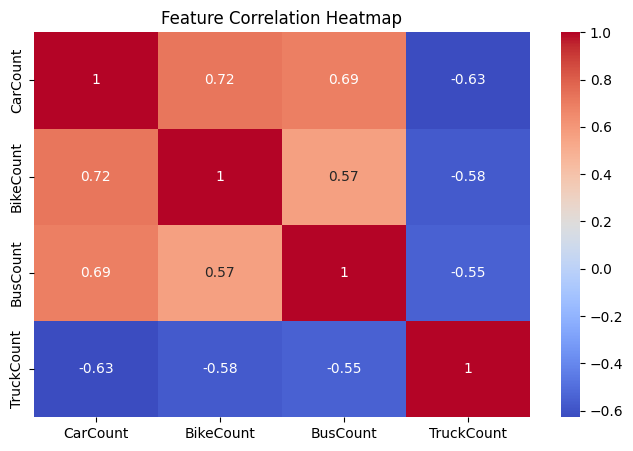

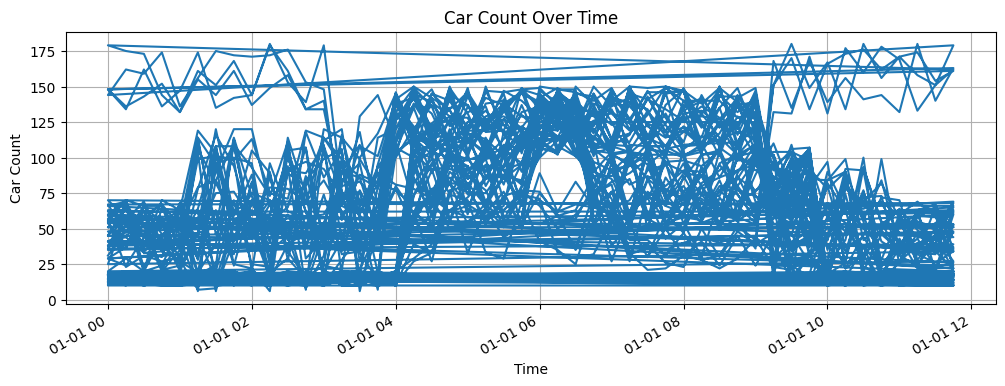

In [46]:
# Correlation heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(data[features].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Time-series plot
plt.figure(figsize=(12, 4))
data['CarCount'].plot()
plt.title('Car Count Over Time')
plt.ylabel('Car Count')
plt.grid(True)
plt.show()

# 5| Train the LSTM Model

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))
model.add(Activation('softmax'))  # softmax activation function
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Summary of the model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 50)                  │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,051 (43.17 KB)

 Trainable params: 11,051 (43.17 KB)

 Non-trainable params: 0 (0.00 B)

# 6|  Split the Data (80% Train, 20% Test)

In [48]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (no shuffle to preserve time sequence)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 7| Train, Evaluate and Visualization

Epoch 1/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7499 - loss: 0.5198 - val_accuracy: 0.8456 - val_loss: 0.3901
Epoch 2/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8567 - loss: 0.3491 - val_accuracy: 0.8491 - val_loss: 0.3583
Epoch 3/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8612 - loss: 0.3332 - val_accuracy: 0.8508 - val_loss: 0.3619
Epoch 4/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8759 - loss: 0.3159 - val_accuracy: 0.8473 - val_loss: 0.3695
Epoch 5/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8516 - loss: 0.3375 - val_accuracy: 0.8491 - val_loss: 0.3512
Epoch 6/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8729 - loss: 0.3111 - val_accuracy: 0.8456 - val_loss: 0.3580
Epoch 7/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8810 - loss: 0.3036 - val_accuracy: 0.8491 - val_loss: 0.3395
Epoch 8/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8798 - loss: 0.2937 - val_accu

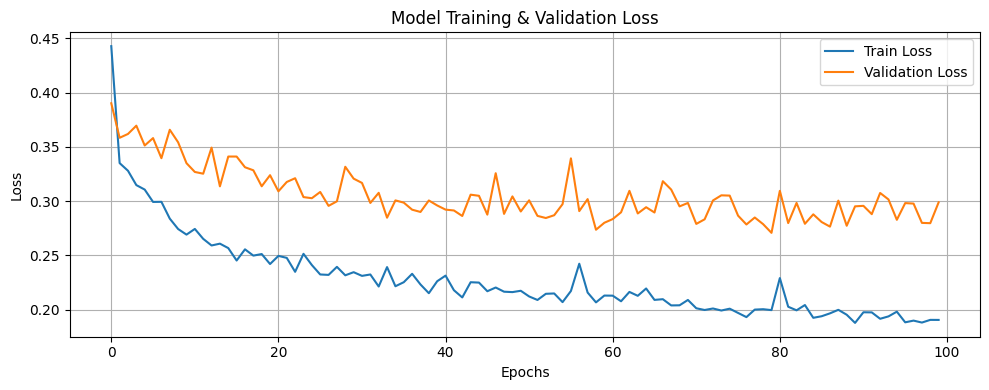

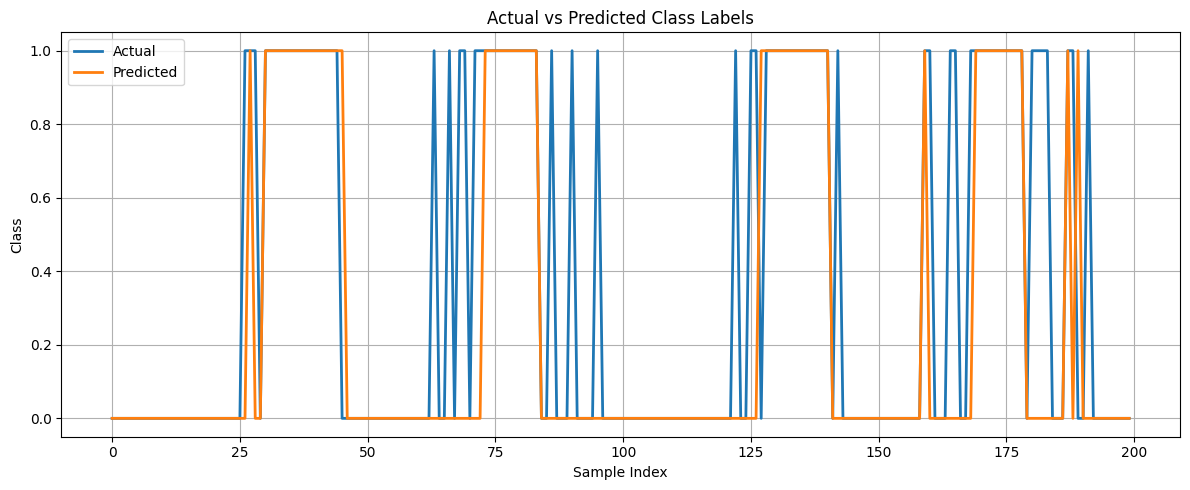

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

# Convert continuous labels to class labels (binary classification: 0 or 1)
y_train_class = np.round(y_train).astype(int)
y_test_class = np.round(y_test).astype(int)

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dense(2, activation='softmax'))  # Softmax for 2-class classification
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with batch size 16
history = model.fit(
    X_train, y_train_class,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test_class),
    verbose=1
)

# Predict class probabilities
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Evaluation
print("Accuracy:", accuracy_score(y_test_class, y_pred_classes))
print("Precision:", precision_score(y_test_class, y_pred_classes, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test_class, y_pred_classes, average='weighted', zero_division=0))
print("F1 Score:", f1_score(y_test_class, y_pred_classes, average='weighted', zero_division=0))

# Visualize training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize actual vs predicted class labels
plt.figure(figsize=(12, 5))
plt.plot(y_test_class[:200], label='Actual', linewidth=2)
plt.plot(y_pred_classes[:200], label='Predicted', linewidth=2)
plt.title("Actual vs Predicted Class Labels")
plt.xlabel("Sample Index")
plt.ylabel("Class")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()